# **Text Classification using BERT**


# **Milestone 1: Learning and understanding the BERT ML technique and its significance in NLP.**

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
!pip install transformers
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

%matplotlib inline

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(7,6))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

--2024-12-14 03:16:59--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 173.194.203.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv’

finance_test.csv    100%[===================>]  28.58K  --.-KB/s    in 0s      

2024-12-14 03:16:59 (135 MB/s) - ‘finance_test.csv’ saved [29264/29264]

--2024-12-14 03:16:59--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 173.194.203.207, 142.250.107.207, ...
Connecting to storage.googlea

# **Preprocessing data for BERT and training our model.**



## **Reading in the Datasets**

Just as in previous notebooks, use the `get_finance_train()` and `get_finance_test()` methods to get the train and test datasets and save them in variables named `df_train` and `df_test` respectively.

In [ ]:
df_train = get_finance_train()
df_test = get_finance_test()

For simplicity, save sentences and labels columns of `df_train` in variables named `sentences` and `labels` respectively.


**Note: To access a column from a dataframe based on the column name, you can use the code structure: `column = df_train["column_name"].values`. Replace `column_name` with your desired column to access it.**

In [ ]:
sentences = df_train["Sentence"].values
labels = df_train["Label"].values

## **Tokenization & Input Formatting**

Just as before, we need to break down our input sentences to smaller tokens. BERT expects input sentences to be broken down into individual tokens and the input data needs to follow BERT's pre-defined format.

### BERT Tokenizer ###

The BERT Tokenizer is a two-step process in processing our data. First, we will initialize the tokenizer using our dataset. Thereafter, we will convert the original sentences to tokenized sentences.

#### Step 1 : Create the Tokenizer ####

#### **Tokenize with Bert**

When using BERT, our text needs to be split into tokens and those tokens need to be mapped to an index using BERT's vocabulary. We will use the `BertTokenizer` module from the transformer library to tokenize our data. To do so, call the function `BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)` and save the returned value in a variable named `tokenizer`.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### **Vocabulary Size**

The BERT Tokenizer object you created keeps track of the size of the vocabulary we are dealing with in this dataset. Find and print the number of unique tokens in the BERT model by calling `tokenizer.vocab_size`.

In [ ]:
print(tokenizer.vocab_size)

30522


#### **Applying the tokenizer**

Apply the tokenizer to the first element in your training dataset: `sentences[0]`. To do so, call the `tokenizer.tokenize(SENTENCE)` function while passing in your sentence in place of `SENTENCE` as shown. Print the original sentence relative to the tokenized sentence.

In [ ]:
tokenized_sentence = tokenizer.tokenize(sentences[0])

#### Step 2 : Map the tokens to our index ####

Each token has a corresponding index in the vocabulary. To keep track of the vector representations more concisely, we will convert each of the tokenized lists into a list of indices.



#### **Map tokens to indices**

Map the tokens to indices on the first element in your training dataset: `sentences[0]`. To do so,  use the `convert_tokens_to_ids()` function of the `tokenizer` to encode our word tokens into numerical values. Call the command `tokenizer.convert_tokens_to_ids(TOKENIZED_SENTENCE)` passing in the tokenized version of `sentences[0]` that you created above for `TOKENIZED_SENTENCE`. Print the tokenized sentence relative to the mapped indices sentence.

In [ ]:
tokenizer.convert_tokens_to_ids(tokenized_sentence)

[8285,
 5794,
 2243,
 2177,
 2003,
 2112,
 1997,
 2004,
 6873,
 1005,
 1055,
 3001,
 2407,
 1012]

### Text Formatting ###

When using BERT, we need to modify our input to match the BERT Format. To do so, we will apply these three steps on the input sentences:

1. Add special tokens to the start (`[CLS]`) and end (`[SEP]`) of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

Take note of the visualization on **Sentence A** below that elucidates these steps. However, let us understand each of these steps in more detail before proceeding to apply them to our dataset.

#### **Special Tokens** ####

These are two tokens we add to the start and end respectively:



*   `[CLS]` - stands for "classification," and is used to identify new sentences.
*   `[SEP]` - stands for "separator," and identifies if a pair of sentences are consecutive in a corpus or not (used for next sentence prediction).



#### **Add special tokens**

We want to add these special tokens to the start and end of each one of our preprocessed sentences. To do so, fill out the code below to loop through your `sentences` array and create a new sentence that adds `"[CLS] "` to the start of the sentence and that adds `" [SEP]"` to the end of the sentence. Add the newly modified sentence to the list variable named `sentences_with_special_tokens`.

**Note: When you add the `"[CLS] "` string to the front of the sentence, ensure that you add it with the space character at the end as shown. Similarly, add the `" [SEP]"` string to the end of the sentence with a space character at the start as shown.**

In [ ]:
sentences_with_special_tokens = []
for i in sentences:
  new_sentence = "[CLS] " + i + " [SEP]"
  sentences_with_special_tokens.append(new_sentence)
print(sentences_with_special_tokens)

["[CLS] Autotank Group is part of Aspo 's Systems Division . [SEP]", '[CLS] The contract includes design , construction , delivery of equipment , installation and commissioning . [SEP]', '[CLS] Rapala said it estimates it will make savings of 1-2 mln eur a year by centralising its French operations at one site . [SEP]', '[CLS] The share capital of Alma Media Corporation (business ID 1944757-4)is EUR 45,031,513.80 and it is divided into 75,052,523 shares . [SEP]', "[CLS] The financial impact is estimated to be some 1.5 MEUR annual improvement in the division 's result , starting from fiscal year 2007 . [SEP]", '[CLS] The hull of the vessel was built one block at a time and Ruukki delivered the plate material for each block as construction progressed . [SEP]', '[CLS] Construction is expected to be completed in the summer of 2011 . [SEP]', '[CLS] Operating profit rose from EUR 1.94 mn to EUR 2.45 mn . [SEP]', '[CLS] The inventors are Bylander Johan , Ponten Fredrik and Lundberg Jorgen . [

#### **Tokenize your sentences**

Now we will tokenize our new list of input sentences using our BERT `tokenizer`. Do so by looping through your new `sentences_with_special_tokens` list and apply `tokenizer.tokenize(SENTENCE)` to each sentence. Add each tokenized sentence to a list named `tokenized_texts`.

In [ ]:
tokenized_texts = []
for i in sentences_with_special_tokens:
  tokenized_texts.append(tokenizer.tokenize(i))
print(tokenized_texts)

[['[CLS]', 'auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.', '[SEP]'], ['[CLS]', 'the', 'contract', 'includes', 'design', ',', 'construction', ',', 'delivery', 'of', 'equipment', ',', 'installation', 'and', 'commissioning', '.', '[SEP]'], ['[CLS]', 'rap', '##ala', 'said', 'it', 'estimates', 'it', 'will', 'make', 'savings', 'of', '1', '-', '2', 'ml', '##n', 'eu', '##r', 'a', 'year', 'by', 'central', '##ising', 'its', 'french', 'operations', 'at', 'one', 'site', '.', '[SEP]'], ['[CLS]', 'the', 'share', 'capital', 'of', 'alma', 'media', 'corporation', '(', 'business', 'id', '1944', '##75', '##7', '-', '4', ')', 'is', 'eu', '##r', '45', ',', '03', '##1', ',', '51', '##3', '.', '80', 'and', 'it', 'is', 'divided', 'into', '75', ',', '05', '##2', ',', '52', '##3', 'shares', '.', '[SEP]'], ['[CLS]', 'the', 'financial', 'impact', 'is', 'estimated', 'to', 'be', 'some', '1', '.', '5', 'me', '##ur', 'annual', 'improvement', 'in', 'the', 'divis

#### **Sentence Length** ####

Since our input has sentences of varying length, we need to pad them to be the same length. BERT has the follow constraints on sentence length:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

In order to handle this, every input sequence is padded to pre-defined fixed length with a special `[PAD]` token, which pads the sequence with zeros.


#### **Encode tokenized sentences with indices**

Before we properly pad the sentences, we will first map each token to its corresponding index for each tokenized sentence. To do so, we will loop through your `tokenized_texts` variable call the `tokenizer.convert_tokens_to_ids(TOKENIZED_SENTENCE)` while passing in your tokenized sentence to convert it to a list of corresponding indices. Add each converted list to the variable named `input_ids`.

In [ ]:
input_ids = []
for txt in tokenized_texts:
    input_ids.append(tokenizer.convert_tokens_to_ids(txt))

#### **Padding your input**

Now we will pad our input to ensure that every sequence has the same length. To do so, we will utilize the `keras` function named `pad_sequences()`. Call the function below to properly pad your sequences. We want to pad every sequence to a length of `128`, so ensure that you pass in `128` for `maxlen` in the function call. Print the first element of your new `input_ids` to observe the new padded sequence.

In [ ]:
input_ids = pad_sequences(input_ids,
                          maxlen=128, # Set a fixed maxlen value
                          dtype="long",
                          truncating="post",
                          padding="post")

####**Attention Masks**####

An Attention Mask is an array of 1s and 0s indicating which tokens are padding and which are not. The idea behind attention masks is that we do not want the extra padded sequence tokens to contribute to the input features of the machine learning model. So, we essentially zero them out to highlight their insignificance before passing them through the model.

Each sequence has a corresponding attention mask. Consider the input sequence below and its corresponding attention mask. We want to create an attention mask for each sequence before passing our data through the BERT model.






#### **Create attention masks**

Create an attention mask for each sequence in your `input_ids` list. The attention mask for a particular tokenized sequence will have the same exact length and will have a `1.0` at every index that there is a token and a `0.0` at every index that there is a padding. Loop through your `input_ids` and for each sequence create a corresponding attention mask and add it to the `attention_masks` list.

**Hint: To get the attention mask given a tokenized sequence, you may use the line of code `mask=[float(i>0) for i in SEQUENCE]` where `SEQUENCE` is an element of your `input_ids` list.**

In [ ]:
attention_masks = []
for sequence in input_ids: # This line is likely the problem
  mask = [float(i>0) for i in sequence]
  attention_masks.append(mask)

X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.15, random_state=RND_SEED) # Call train_test_split to split the data

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.15, random_state=RND_SEED) # Call train_test_split to split the attention masks # The second argument here should be labels not input_ids

## **Setting up your Data for BERT**

Finally, we need to split our data and convert it to objects that will work most efficiently with the BERT model training procedure. Specifically, we will split our training data into training and validation sets. Additionally, we will convert our data objects into `tensor` s such that we can easily feed the input into the model.

#### **Train/Test Split**

To run machine learning models, we first need to split our dataset into training and validation sections. We can do so by using the `train_test_split()` function. One call to this function returns four separate items:
  1. X_train
  2. X_val
  3. y_train
  4. y_val

We will save these returned elements in variables with respective names. Call the `train_test_split()` function, passing in `input_ids`, `labels`, `test_size=0.15`, and `random_state=RND_SEED`.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.15, random_state=RND_SEED) # Call train_test_split to split the data

We also want to split our attention masks in the same way. Similarly, call the `train_test_split()` function, passing in `attention_masks`, `input_ids`, `test_size=0.15`, and `random_state=RND_SEED`. However, we only need to save the first two returned items in variables named `train_masks` and `validation_masks`.

In [ ]:
from sklearn.model_selection import train_test_split

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.15, random_state=RND_SEED) # Call train_test_split to split the attention masks

In addition to converting our data to `tensor`, `tensorflow` array objects, we will also create a `DataLoader` for our input. A `DataLoader` is simply an object that simplifies and streamlines feeding in data to our model.

In [ ]:
#@title Run this cell to convert data to tensors and create DataLoaders
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); # Samples data randonly for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); # Samples data sequentially
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

# **Milestone 3: Running and finetuning our BERT model with the PyTorch huggingface transformer library.**





To use BERT in our sentiment analysis, we first want to modify BERT to output either a positive, neutral, or negative classification. Next,  we want to train the model on our dataset so that the entire model, end-to-end, is well-suited to our task.

The huggingface PyTorch implementation includes a set of interfaces designed for a variety of NLP tasks. These interfaces are all built on top of a pre-trained BERT model, and each has different top layers and output types designed to accomodate their specific NLP task. (An analogy: imagine BERT is a garden hose; then the huggingface PyTorch interfaces are like different nozzles for the garden hose, so we can use it for "jet," "mist," etc.)

For our sentiment classification task we will use:

* **BertForSequenceClassification** - This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


The documentation for this can be found [here](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification).

In [ ]:
#@title Run this cell to initialize your BertForSequenceClassification model
#Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT small model, with an uncased vocab.
    num_labels = 3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
);

# Given that this a huge neural network, we need to explicity specify
# in pytorch to run this model on the GPU.
model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'Tesla T4'

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, ### YOUR CODE HERE
                  eps = 1e-8
                )
epochs = 4

In [ ]:
#@title Run this cell to train your model!

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# We'll store training and validation loss,
# validation accuracy, and timings.
training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode.
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # STEP 1 & 2: Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # STEP 3
        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # STEP 4
        # Perform a forward pass (evaluate the model on this training batch).
        # It returns the loss (because we provided labels) and
        # the "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # STEP 5
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # STEP 6
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Evaluating on Validation Set")
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        # Unpack this validation batch from our dataloader.

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("Validation Loss: {0:.2f}".format(avg_val_loss))


    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.64
Evaluating on Validation Set
Validation Accuracy: 0.82
Validation Loss: 0.38
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.21
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.13
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.08
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.11
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.04
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.11
Training complete!


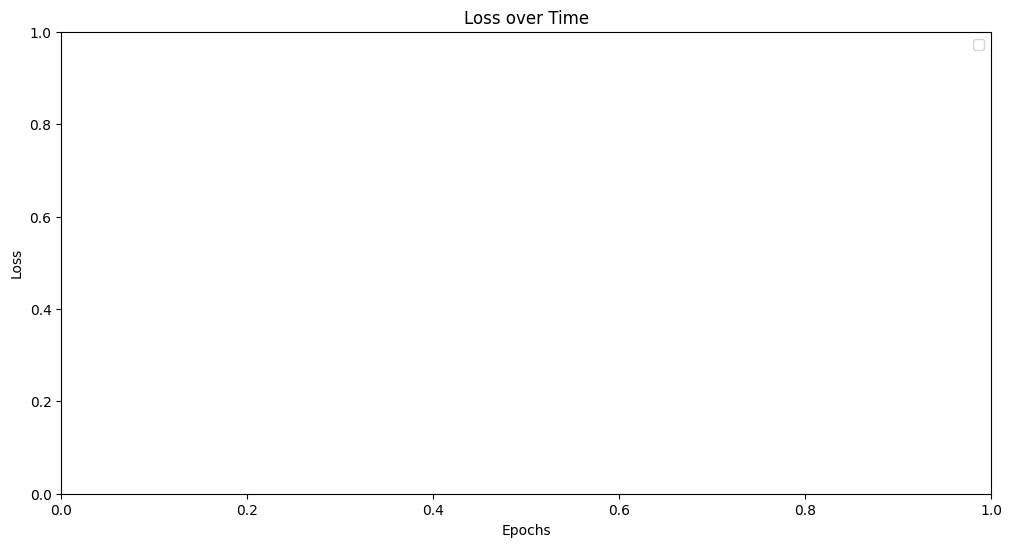

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
#@title Run this cell to process and prepare our test data!
test_input_ids, test_attention_masks = [], []

# Assuming df_test contains the test data
test_sentences = df_test["Sentence"].values  # Get test sentences from df_test
test_labels = df_test["Label"].values # Get the labels from df_test

# Add Special Tokens
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

# Tokenize sentences
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

# Encode Tokens to Word IDs
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

# Pad the inputs
test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

# Create Attention Masks
for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [ ]:
#@title Run this cell to convert data to tensors and create DataLoaders
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Predicting labels for 227 test sentences...
Test Accuracy: 98.24%
Plotting the Confusion Matrix


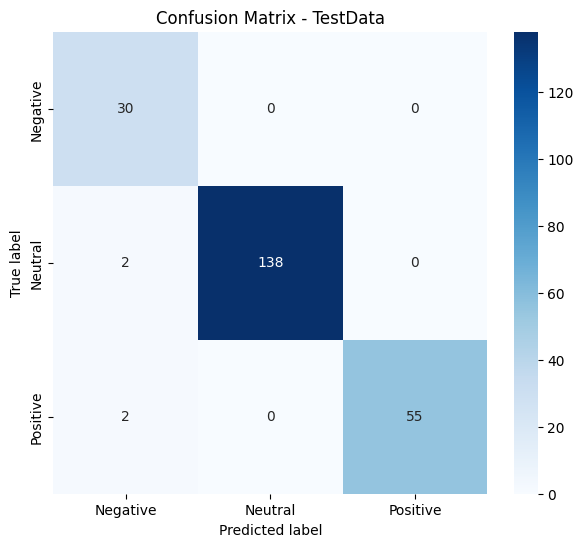

In [ ]:
#@title Evaluate Test Set Accuracy!
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Final tracking variables
y_logits, y_true, y_preds = [], [], []

# Gather logit predictions
for chunk in predictions:
  for logits in chunk:
    y_logits.append(logits)

# Gather true labels
for chunk in true_labels:
  for label in chunk:
    y_true.append(label)

# Gather real predictions
for logits in y_logits:
  y_preds.append(np.argmax(logits))

print ('Test Accuracy: {:.2%}'.format(metrics.accuracy_score(y_preds,y_true)))
plot_confusion_matrix(y_true,y_preds)